# Ordered MNIST digits examample from Kostic et al. NeurIPS 2022

## Data pipeline

In [1]:
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml')

In [2]:
#Data pipeline
from datasets import load_dataset, interleave_datasets, DatasetDict
MNIST = load_dataset('mnist', keep_in_memory=True)
digit_ds = []
for i in range(configs.classes):
    digit_ds.append(MNIST.filter(lambda example: example['label'] == i, keep_in_memory=True, num_proc=8))
ordered_MNIST = DatasetDict()
#Order the digits in the dataset and select only a subset of the data
for split in ['train', 'test']:
    ordered_MNIST[split] = interleave_datasets([ds[split] for ds in digit_ds], split=split).select(range(configs[f'{split}_samples']))
_tmp_ds = ordered_MNIST['train'].train_test_split(test_size=configs.val_ratio, shuffle=False)
ordered_MNIST['train'] = _tmp_ds['train']
ordered_MNIST['validation'] = _tmp_ds['test']

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/60000 [00:00<?, ? examples/s]

Filter (num_proc=8):   0%|          | 0/10000 [00:00<?, ? examples/s]

train(800) example: [0, 1, 2, 3, 4]
test(1001) example: [0, 1, 2, 3, 4]
validation(201) example: [0, 1, 2, 3, 4]


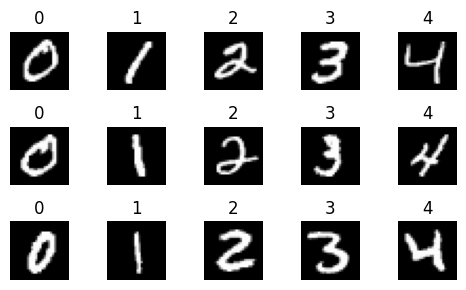

In [3]:
#Checking the data
import matplotlib.pyplot as plt
fig, ax = plt.subplots(3, configs.classes, figsize=(configs.classes, 3))

for j, split in enumerate(['train', 'test', 'validation']):
    print(f'{split}({len(ordered_MNIST[split])}) example: {ordered_MNIST[split]["label"][:configs.classes]}')
    for i in range(configs.classes):
        data = ordered_MNIST['train'][configs.classes*j + i]
        ax[j, i].imshow(data['image'], cmap='gray')
        ax[j, i].set_title(data['label'])
        ax[j, i].axis('off')
fig.tight_layout()

In [4]:
#Cast to float32 and normalize to [0, 1]
ordered_MNIST.set_format(type='torch', columns=['image', 'label'])
ordered_MNIST = ordered_MNIST.map(lambda example: {'image': example['image']/255.0, 'label': example['label']}, batched=True, keep_in_memory=True, num_proc=2)
#Creating a copy of the dataset in numpy format
np_ordered_MNIST = ordered_MNIST.with_format(type='numpy', columns=['image', 'label'])

Map (num_proc=2):   0%|          | 0/800 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/1001 [00:00<?, ? examples/s]

Map (num_proc=2):   0%|          | 0/201 [00:00<?, ? examples/s]

## Setting up a validation scheme
The validation of each model will be performed as follows: starting from a test image of the digit $c$, we will predict the next image by calling `model.predict`. The prediction should be an MNIST-alike image of the digit $c+1$ (modulo `configs.classes`). We will feed this prediction to a very strong MNIST classifier, and evaluate how its accuracy degrades over time.

### Defining the _oracle_ classifier

In [5]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1) # add channel dimension if needed
            
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

We wrap the oracle classifier around a `kooplearn.abc.TrainableFeatureMap`. This will allow us to easily replicate the setting of Kostic et al. 2022, and it is pedagogical to show how `kooplearn` can be extended.

In [6]:
import logging
import os
import lightning
import numpy as np
from pathlib import Path
import pickle
from kooplearn.abc import TrainableFeatureMap
from typing import Optional

#Following kooplearn implementations, we define a Pytorch Lightning module
class ClassifierModule(lightning.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        with torch.no_grad():
            pred_labels = output.argmax(dim=1)
            accuracy = (pred_labels == labels).float().mean()
        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)  
        pred_labels = output.argmax(dim=1)
        accuracy = (pred_labels == labels).float().mean() # Scalar
        return {'accuracy': accuracy}
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer_kwargs: dict,
                seed: Optional[int] = None  
                ):
        #Set rng seed
        lightning.seed_everything(seed)
        self.seed = seed
        self._lightning_module = ClassifierModule(num_classes, learning_rate)
        
        #Init trainer
        self.trainer = lightning.Trainer(**trainer_kwargs)
        
        self._storage = {
            'num_classes': num_classes,
            'learning_rate': learning_rate,
            'trainer_kwargs': trainer_kwargs,
            'seed': seed
        }
        self._trainer_kwargs = trainer_kwargs
        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    @property
    def lookback_len(self) -> int:
        return 1 #Hardcoding it here, as we are not using lookback windows
    
    def save(self, path: os.PathLike):
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        ckpt = path / 'weights.ckpt'
        params = path / 'params.pkl'
        self.trainer.save_checkpoint(str(ckpt))
        self._storage['is_fitted'] = self._is_fitted
        with open(params, 'wb') as f:
            pickle.dump(self._storage, f)

    @classmethod
    def load(cls, path: os.PathLike):
        with open(Path(path) / 'params.pkl', 'rb') as f:
            storage = pickle.load(f)
        _is_fitted = storage.pop('is_fitted')
        feature_map = cls(**storage)
        feature_map._is_fitted = _is_fitted
        ckpt = Path(path) / 'weights.ckpt'
        feature_map._lightning_module = ClassifierModule.load_from_checkpoint(str(ckpt))
        return feature_map

    def fit(self, **trainer_fit_kwargs: dict):
        if 'model' in trainer_fit_kwargs:
            logging.warn("The 'model' keyword should not be specified in trainer_fit_kwargs. The model is automatically set to the DPNet feature map, and the provided model is ignored.")
            trainer_fit_kwargs = trainer_fit_kwargs.copy()
            del trainer_fit_kwargs['model']
        self.trainer.fit(model=self._lightning_module, **trainer_fit_kwargs)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X).float()
        X.to(self._lightning_module.device)
        self._lightning_module.eval()
        with torch.no_grad():
            embedded_X = self._lightning_module.encoder(X)
            embedded_X = embedded_X.detach().numpy()
        return embedded_X

Let's train `ClassifierFeatureMap` on our `ordered_MNIST` dataset

In [7]:
from torch.utils.data import DataLoader
train_dl = DataLoader(ordered_MNIST['train'], batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(ordered_MNIST['validation'], batch_size=len(ordered_MNIST['validation']), shuffle=False)

#Metrics Logging
from lightning.pytorch.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_acc = []
        self.train_steps = []
        self.val_acc = []
        self.val_steps = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Get the metrics from the last training step
        self.train_acc.append(outputs['accuracy'].item())
        self.train_steps.append(trainer.global_step)
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx = 0):
        # Get the metrics from the last validation step
        self.val_acc.append(outputs['accuracy'].item())
        self.val_steps.append(trainer.global_step)
        
metrics = MetricsCallback()
trainer_kwargs = {
    'accelerator': 'cpu',
    'max_epochs': 20,
    'log_every_n_steps': None,
    'callbacks': [metrics]
}

oracle = ClassifierFeatureMap(
    configs.classes,
    1e-2,
    trainer_kwargs, 
    seed=configs.rng_seed
)

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") #Ignore warnings about num_workers

oracle.fit(train_dataloaders=train_dl, val_dataloaders=val_dl)

Global seed set to 0
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/pietronovelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | CNNEncoder       | 21.1 K
1 | loss_fn | CrossEntropyLoss | 0     
---------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/pietronovelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


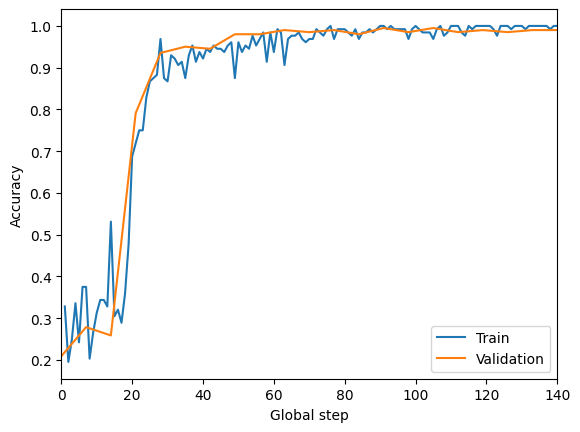

In [8]:
plt.plot(metrics.train_steps, metrics.train_acc, label='Train')
plt.plot(metrics.val_steps, metrics.val_acc, label='Validation')
plt.xlabel('Global step')
plt.ylabel('Accuracy')
plt.legend()
plt.margins(x=0)

In [23]:
import kooplearn.abc
def evaluate_model(model: kooplearn.abc.BaseModel, flatten: bool = True):
    assert model.is_fitted
    test_labels = np_ordered_MNIST['test']['label']
    test_images = np_ordered_MNIST['test']['image']
    if flatten:
        test_images = test_images.reshape(len(test_images),1, -1)
    else:
        test_images = np.expand_dims(test_images, 1)
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': []
    }
    for t in range(1, configs.eval_up_to_t + 1):
        pred = model.predict(test_images, t=t).reshape(-1, 28 ,28)
        pred_labels = oracle(pred)
        pred_labels = pred_labels.argmax(axis=1)
        accuracy = (pred_labels == (test_labels + t)%configs.classes ).mean()
        report['accuracy'].append(accuracy)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

## Fitting some models with `kooplearn`

In [24]:
from kooplearn.models import DMD, KernelDMD, DeepEDMD
from kooplearn._src.context_window_utils import trajectory_to_contexts

In [25]:
context_len = 2
train_data = trajectory_to_contexts(np_ordered_MNIST['train']['image'], context_len)
train_data_flat = train_data.reshape(train_data.shape[0], context_len, -1)

In [26]:
dmd_model = DMD(rank = configs.classes).fit(train_data_flat)
classifier_model = DeepEDMD(oracle, reduced_rank=False, rank=configs.classes).fit(train_data)


In [27]:
report = {}
report['DMD'] = evaluate_model(dmd_model, flatten=True)
report['Classifier'] = evaluate_model(classifier_model, flatten=False)

Text(0.5, 1.0, 'Classifier accuracy')

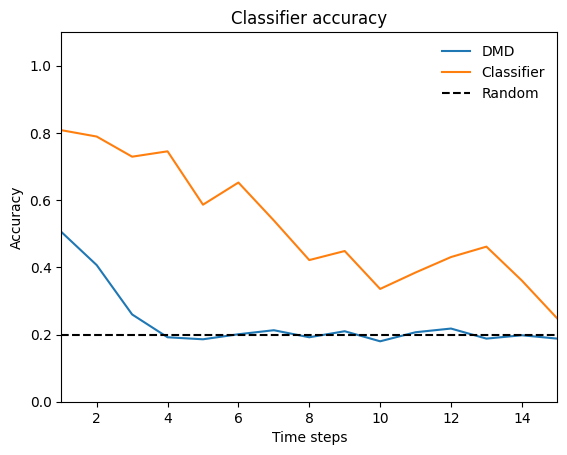

In [29]:
fig, ax = plt.subplots()
for model_name in report.keys():
    t = report[model_name]['times']
    acc = report[model_name]['accuracy']
    ax.plot(t, acc, label=model_name)

ax.axhline(1/configs.classes, color='black', linestyle='--', label='Random')

ax.legend(frameon=False)
ax.margins(x=0)
ax.set_ylim(0, 1.1)
ax.set_xlabel('Time steps')
ax.set_ylabel('Accuracy')
ax.set_title('Classifier accuracy')

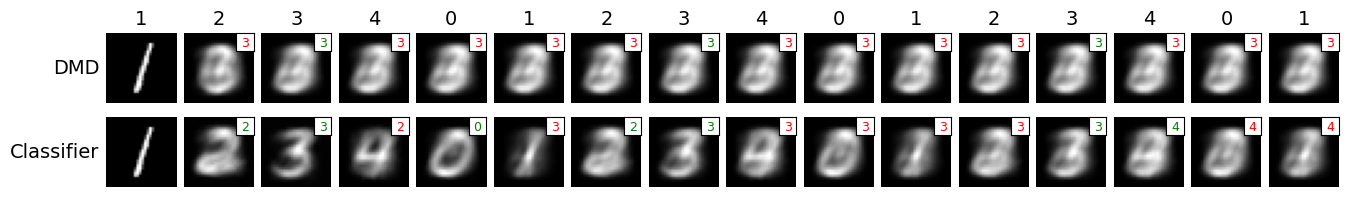

In [33]:
n_models = len(report.keys())
num_cols = configs.eval_up_to_t + 1
fig, axes = plt.subplots(n_models, num_cols, figsize=(num_cols, n_models), sharex=True, sharey=True)

test_seed_idx = 1
# Remove margins between columns
plt.subplots_adjust(wspace=0)

for model_idx, model_name in enumerate(report.keys()):
    ax = axes[model_idx, 0]
    ax.imshow(np_ordered_MNIST['test']['image'][test_seed_idx], cmap='gray')
    # Remove axes and ticks
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    model_eval = report[model_name]

    for t_idx in range(num_cols - 1):
        pred_label = model_eval['label'][t_idx][test_seed_idx]
        true_label = (np_ordered_MNIST['test']['label'][test_seed_idx] + model_eval['times'][t_idx])%configs.classes
        img = model_eval['image'][t_idx][test_seed_idx]
        
        # Set subplot for the current class
        ax = axes[model_idx, t_idx + 1]
        
        # Plot the MNIST image
        ax.imshow(img, cmap='gray')
        
        # Remove axes and ticks
        ax.set_xticks([])
        ax.set_yticks([])
        ax.axis('off')

        # Add a white background for the subplot
        ax.set_facecolor('white')
        
        # Add an inset for the predicted label in the upper right corner
        if pred_label == true_label:
            color = 'green'
        else:
            color = 'red'
        inset_ax = ax.inset_axes([0.75, 0.75, 0.25, 0.25])
        inset_ax.set_xlim(0, 1)
        inset_ax.set_ylim(0, 1)
        inset_ax.text(0.5, 0.4, f"{pred_label}" , color=color, fontsize=9, ha='center', va='center')
        inset_ax.set_xticks([])
        inset_ax.set_yticks([])
        #inset_ax.axis('off')
        inset_ax.set_facecolor('white')
        

# Display the model names on the left of each row
for model_idx, model_name in enumerate(report.keys()):
    axes[model_idx, 0].text(-0.1, 0.5, model_name, fontsize=14, ha='right', va='center', transform=axes[model_idx, 0].transAxes)

for class_idx in range(num_cols):
    title = (np_ordered_MNIST['test']['label'][test_seed_idx] + class_idx)%configs.classes
    axes[0, class_idx].set_title(f"{title}", fontsize=14)

plt.show()